# 지역별 업종으로 살펴보는 제주도 소비데이터 분석

## 목차 

1. 요약
2. 데이터 전처리
3. 제주도 배경개요
4. 주제별 데이터 분석 및 시각화

## 1. 요약

1. 총 소비 금액과 소비 건수가 가장 많은 업종은 음식업종이며, 특히 일반한식 업종이 가장 큰 비율을 차지하고 있음

2. 지역별로는 제주시의 연동, 노형동, 이도이동, 애월읍과 서귀포시의 서귀동, 성산읍, 대정읍, 동홍동 에서 많은 소비가 일어남

3. 상위 업종은 시간대별 패턴이 있음??

4. 재난지원금 소비 금액이 많은 상위 업종으로는 일반한식, 슈퍼마켓, 편의점 등이 있음.

5. 전체 매출에서 재난지원금 사용금액의 비중이 많은 업종으로는 정보서비스, 유류판매, 인삼제품, 마곡상 등이 있음


## 2. 데이터 불러오기

In [ ]:
%%time

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

### 2.1. 라이브러리 

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') #한글 폰트 지정

import folium
#import geopandas as gpd

import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [ ]:
%config InlineBackend.figure_format = 'retina'
 # 한글 폰트 사용하기
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [1]:
path = '/content/drive/My Drive/dacon_jeju_sales'
data_path = '/content/drive/My Drive/dacon_jeju_sales/data'
kosis_path = '/content/drive/My Drive/dacon_jeju_sales/kosis_dataset'
nsdi_path = '/content/drive/My Drive/dacon_jeju_sales/nsdi_dataset'
#os.listdir(path)

### 2.2 데이터 전처리 및 변수 생성하기

생성한 변수는 다음과 같습니다. 전처리 및 생성 코드는 뒤쪽에서 확인할 수 있습니다.
1. 데이터 전처리(기타 1)
2. 좌표를 이용한 읍면동 구분(기타 2)
3. 시간대별 매출변화에 따른 지역/업종별 클러스터링(기타 3)

### 2.3 가공 데이터 불러오기

In [2]:
data5 = pd.read_csv(os.path.join(data_path, '제주도_5월_읍면동추가.csv'))
data6 = pd.read_csv(os.path.join(data_path, '제주도_6월_읍면동추가.csv'))
data7 = pd.read_csv(os.path.join(data_path, '제주도_7월_읍면동추가.csv'))
data8 = pd.read_csv(os.path.join(data_path, '제주도_8월_읍면동추가.csv'))

data = pd.concat([data5, data6, data7, data8])
data = data.reset_index(drop=True)

NameError: ignored

In [ ]:
#행정구역_읍면동(법정동) 경게 데이터, 공간정보포털(http://data.nsdi.go.kr/dataset/15145)
jeju_bound = gpd.read_file(os.path.join(nsdi_path, 'jeju_boundary_wgs84.geojson'))

In [ ]:
#행정구역_읍면동(행정동) 경계 데이터, 공간정보포털(http://data.nsdi.go.kr/dataset/20171206ds00001)
bound2 = gpd.read_file(os.path.join(nsdi_path, '읍면동_행정경게(행정동)/Z_SOP_BND_ADM_DONG_PG.shp'), encoding='euc-kr')
jeju_bound2 = bound2.loc[(bound2['ADM_DR_CD'].str.startswith('3901'))|(bound2['ADM_DR_CD'].str.startswith('3902'))].set_crs(epsg=5181)
jeju_bound2['geometry'] = jeju_bound2['geometry'].to_crs('EPSG:4326')

## 3. 배경 지식 : 제주도 개요

* 제주도는 특별자치도로 섬의 중앙을 기준으로 제주시(북쪽), 서귀포시(남쪽)으로 나눠져있습니다.

In [ ]:
# 제주공항 좌표(33.510481369447554, 126.49145025928517)를 중심으로 맵을 생성
f = folium.Figure(width=600, height=400)

m = folium.Map(location = [33.5104, 126.4914502],
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/5AA2EC51-9D9A-35A1-ABD2-ED58B40D7745/Base/{z}/{y}/{x}.png',
               attr = '제주도',
               zoom_start= 9)

m.add_to(f)

### 3.1. 제주도 소비 데이터

주어진 소비 데이터를 살펴봅시다.

* 소비데이터는 제주시는 약 80만건, 서귀포시는 약 32만건으로 제주시가 약 2.5배 많습니다
* 사업규모로는  영세기업이 639337건으로 전체 57%를 차지하고 있습니다.

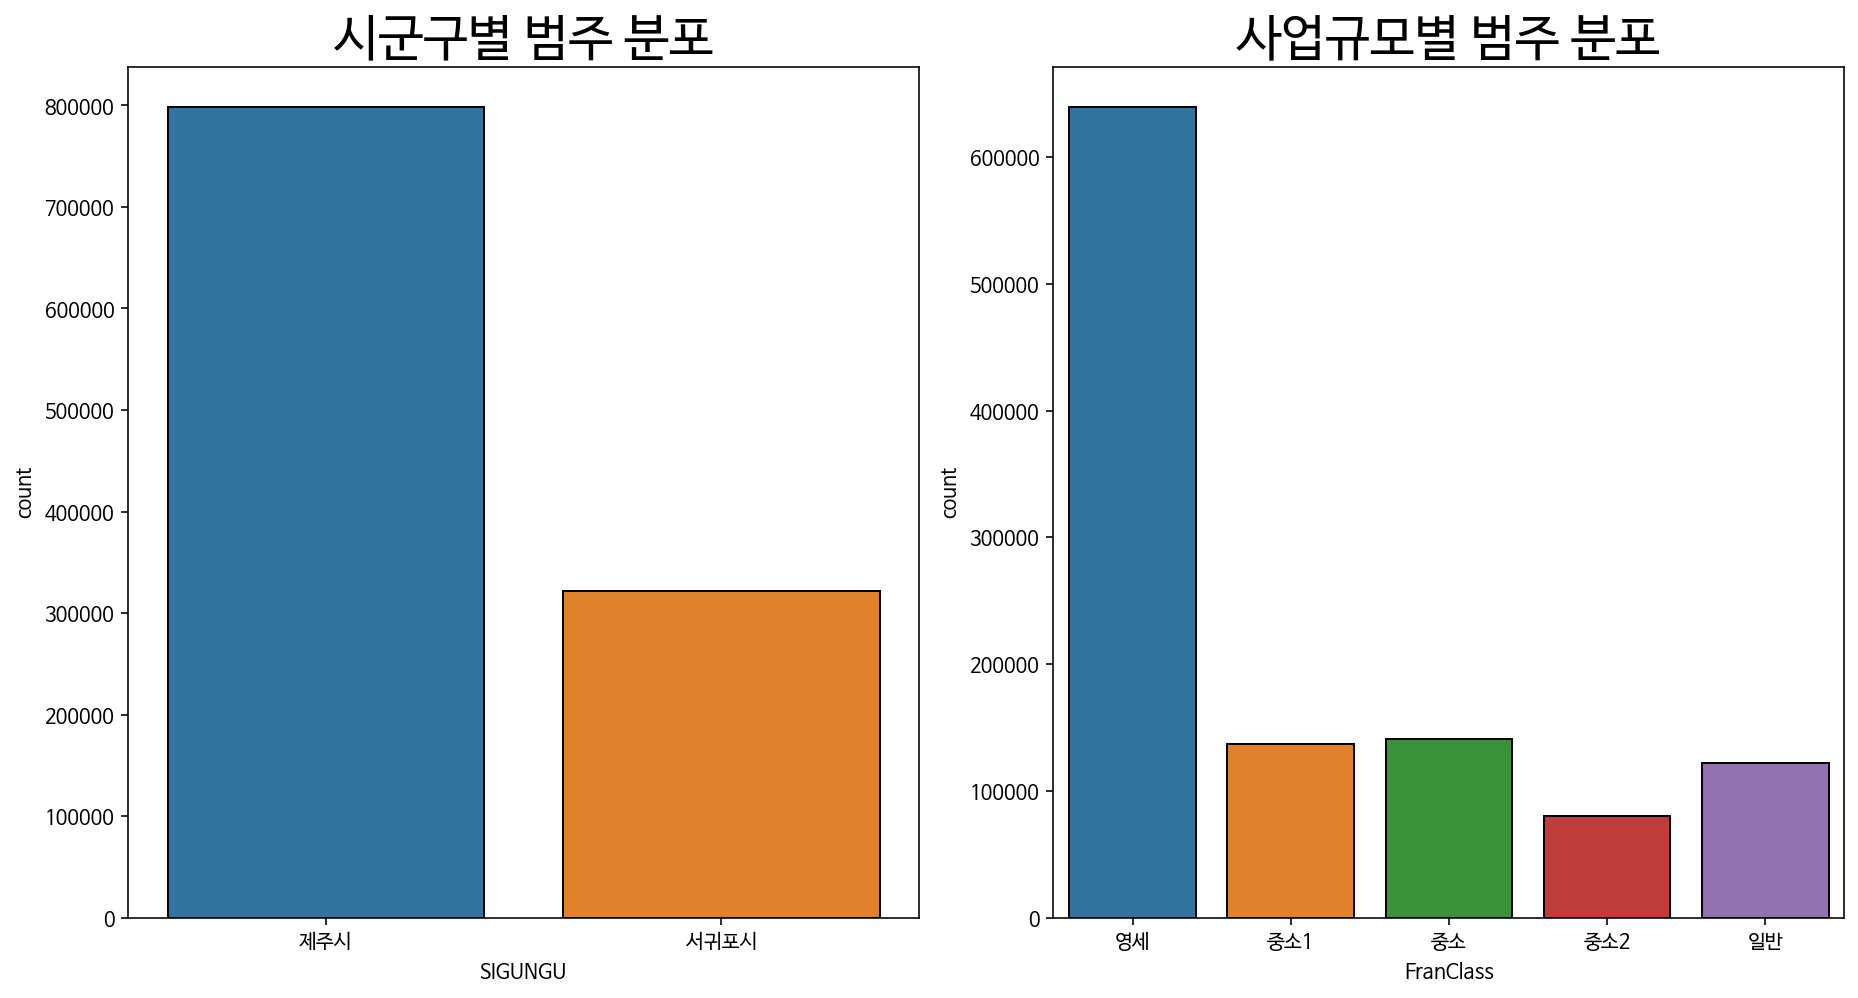

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

sns.countplot(x='SIGUNGU', data=data, ax=axes[0], edgecolor='black')
sns.countplot(x='FranClass', data=data, ax=axes[1], edgecolor='black')

axes[0].set_title('시군구별 범주 분포', fontdict={'fontsize':25})
axes[1].set_title('사업규모별 범주 분포', fontdict={'fontsize':25})

plt.tight_layout()
plt.show()

* 업종별로는 일반한식이 가장 많으며, 전체 데이터의 약 25%를 차지하고 있습니다.
* 편의점, 슈퍼마켓 등 생필품을 구매할 수 있는 업종이 다수 상위에 위치합니다.

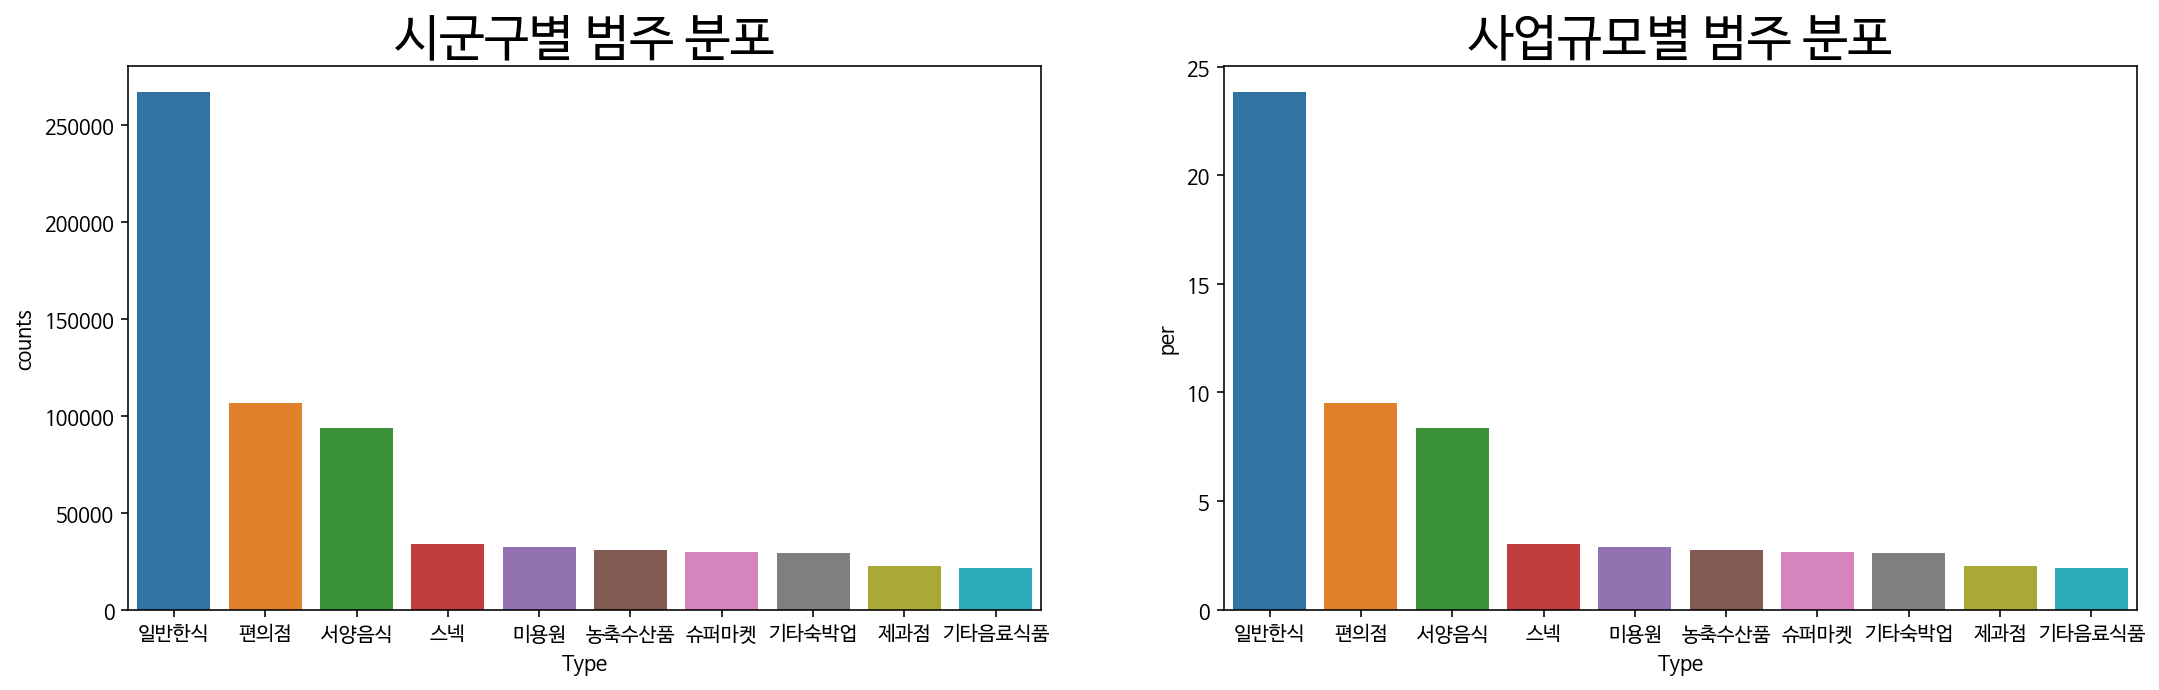

In [ ]:
type_df = data['Type'].value_counts(sort=True)
type_df = type_df.rename_axis('Type').reset_index(name='counts')
type_df['per'] = type_df['counts'] / len(data) * 100
type_df = type_df[:10]

#plot
fig, ax = plt.subplots(1, 2, figsize=(18,5))

sns.barplot(x='Type', y='counts', data=type_df, ax=ax[0])
sns.barplot(x='Type', y='per', data=type_df, ax=ax[1])

ax[0].set_title('시군구별 범주 분포', fontdict={'fontsize':25})
ax[1].set_title('사업규모별 범주 분포', fontdict={'fontsize':25})
plt.show()

### 3.2. 제주도의 인구와 관광객

제주도의 __인구__와 __관광객 수__를 데이터에서 살펴봅니다.

#### 3.2.1. 제주도 인구

* 읍면동 단위 인구 현황 파악
* 2020년 5월 인구수를 기준으로 분석
* 출처 : [Kosis 행정구역(읍면동)별/5세별 주민등록인구(2011년~) 인구데이터](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B04005N&vw_cd=MT_ZTITLE&list_id=A_7&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_ZTITLE)



In [ ]:
people_df = pd.read_csv(os.path.join(kosis_path, '제주도인구_19.5-20.5.csv'), encoding='euc-kr') # 제주도 전체 인구수

people_data = people_df.loc[1][2:].reset_index().rename(columns={'index':'YM', 1:'인구수'})
people_data['인구수'] = people_data['인구수'].astype('int')
people_data['인구수변화율'] = people_data['인구수'].pct_change() * 100

people_df_dong = pd.read_csv(os.path.join(kosis_path, '제주시_읍면동_별_5세별_주민등록인구_202005.csv'), encoding='euc-kr') #읍면동 단위 인구수
people_df_dong.rename(columns={'읍면동': 'dong', '시': 'SIDO'}, inplace=True)
people_df_dong = people_df_dong[['SIDO', 'dong', '계']].sort_values('계', ascending=False)


* 2020년 5월 기준 제주도 인구수는 약 67만명
* 제주도의 인구는 전체적으로 증가하고 있으나 상승폭은 작음
* 제주공항과 도청이 위치한 제주시에 인구가 밀집되어 있음
* 제주시의 인구는 약 49만명으로 18만명인 서귀포시 인구보다 약 2.7배 많음
* 인구가 가장 많은 지역은 54309인 제주시 '노형동' 이며, 가장 적은 지역은 제주시 '추자면'으로 1696명이 살고 있음

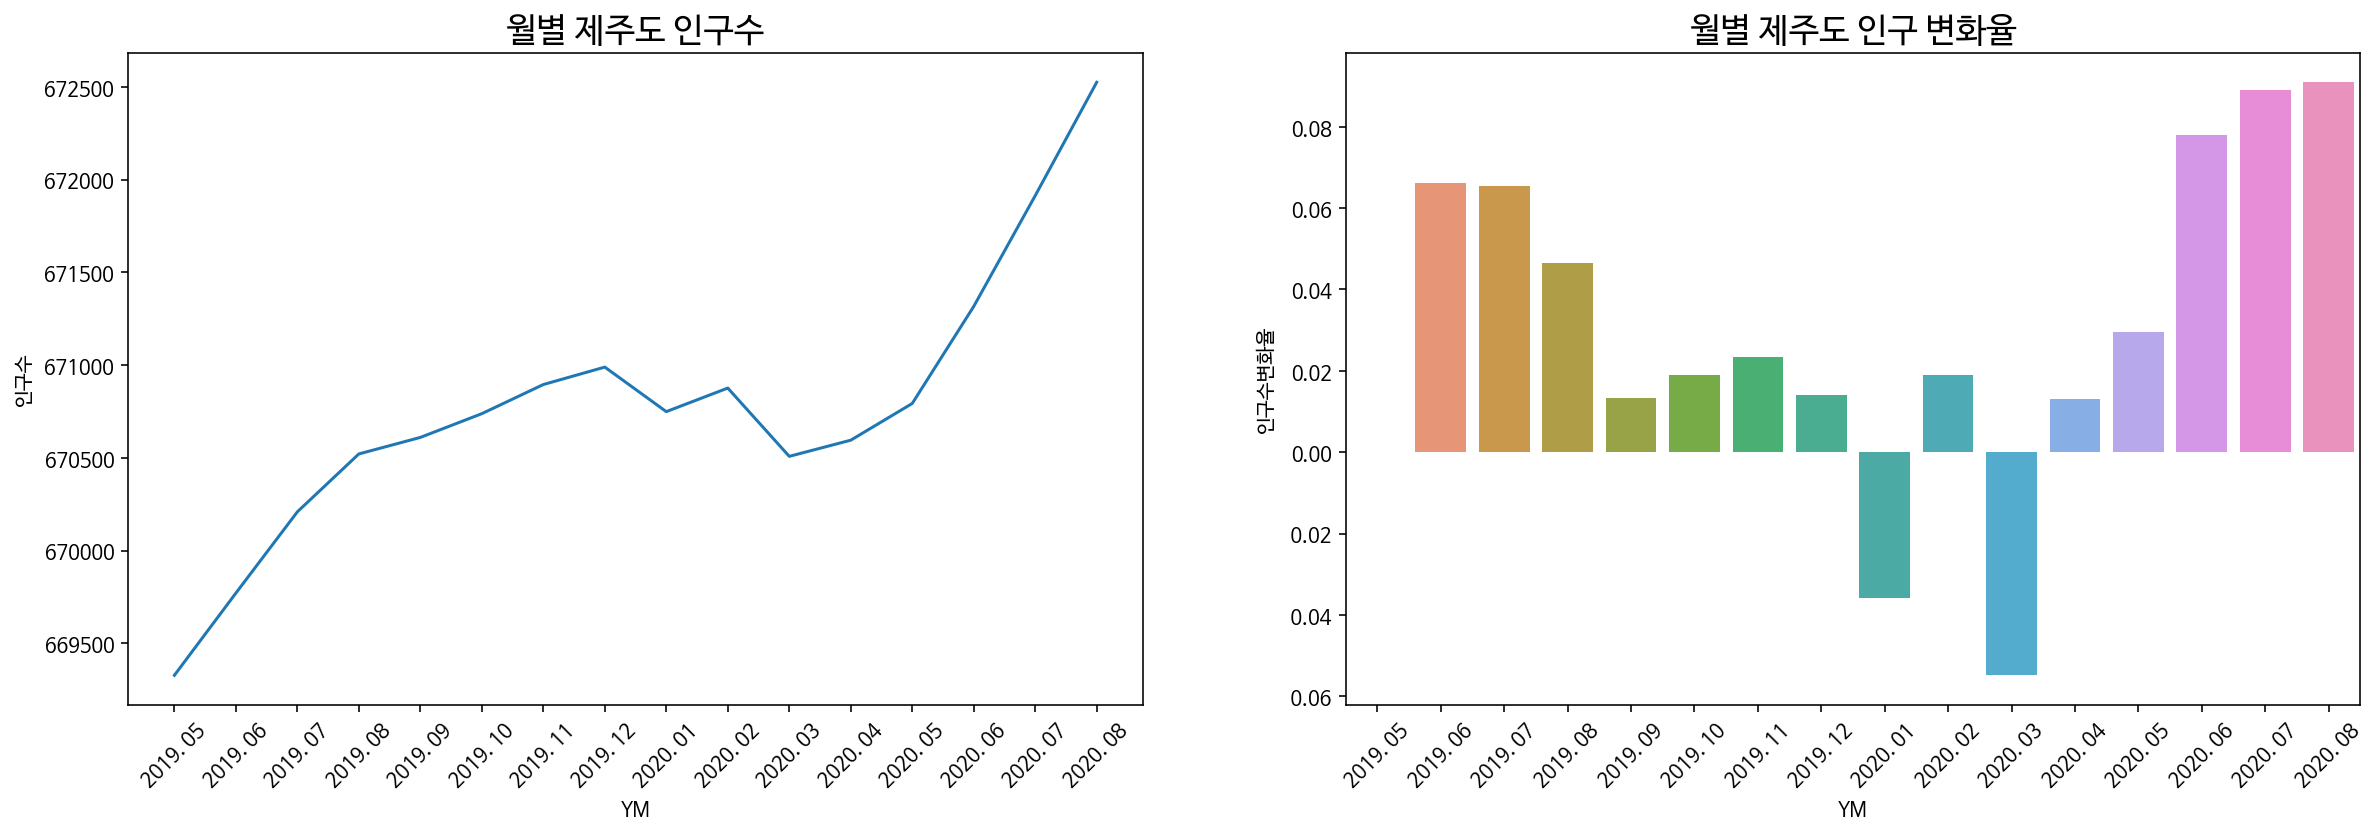

In [ ]:
#plot
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.lineplot(x='YM', y='인구수', data=people_data, ax=ax[0], sort=False)
ax[0].set_title('월별 제주도 인구수', fontsize=17)
ax[0].set_xticklabels(people_data.YM, rotation =45)

sns.barplot(x='YM', y='인구수변화율', data=people_data, ax=ax[1])
ax[1].set_title('월별 제주도 인구 변화율', fontsize=17)
ax[1].set_xticklabels(people_data.YM, rotation =45)
plt.show()

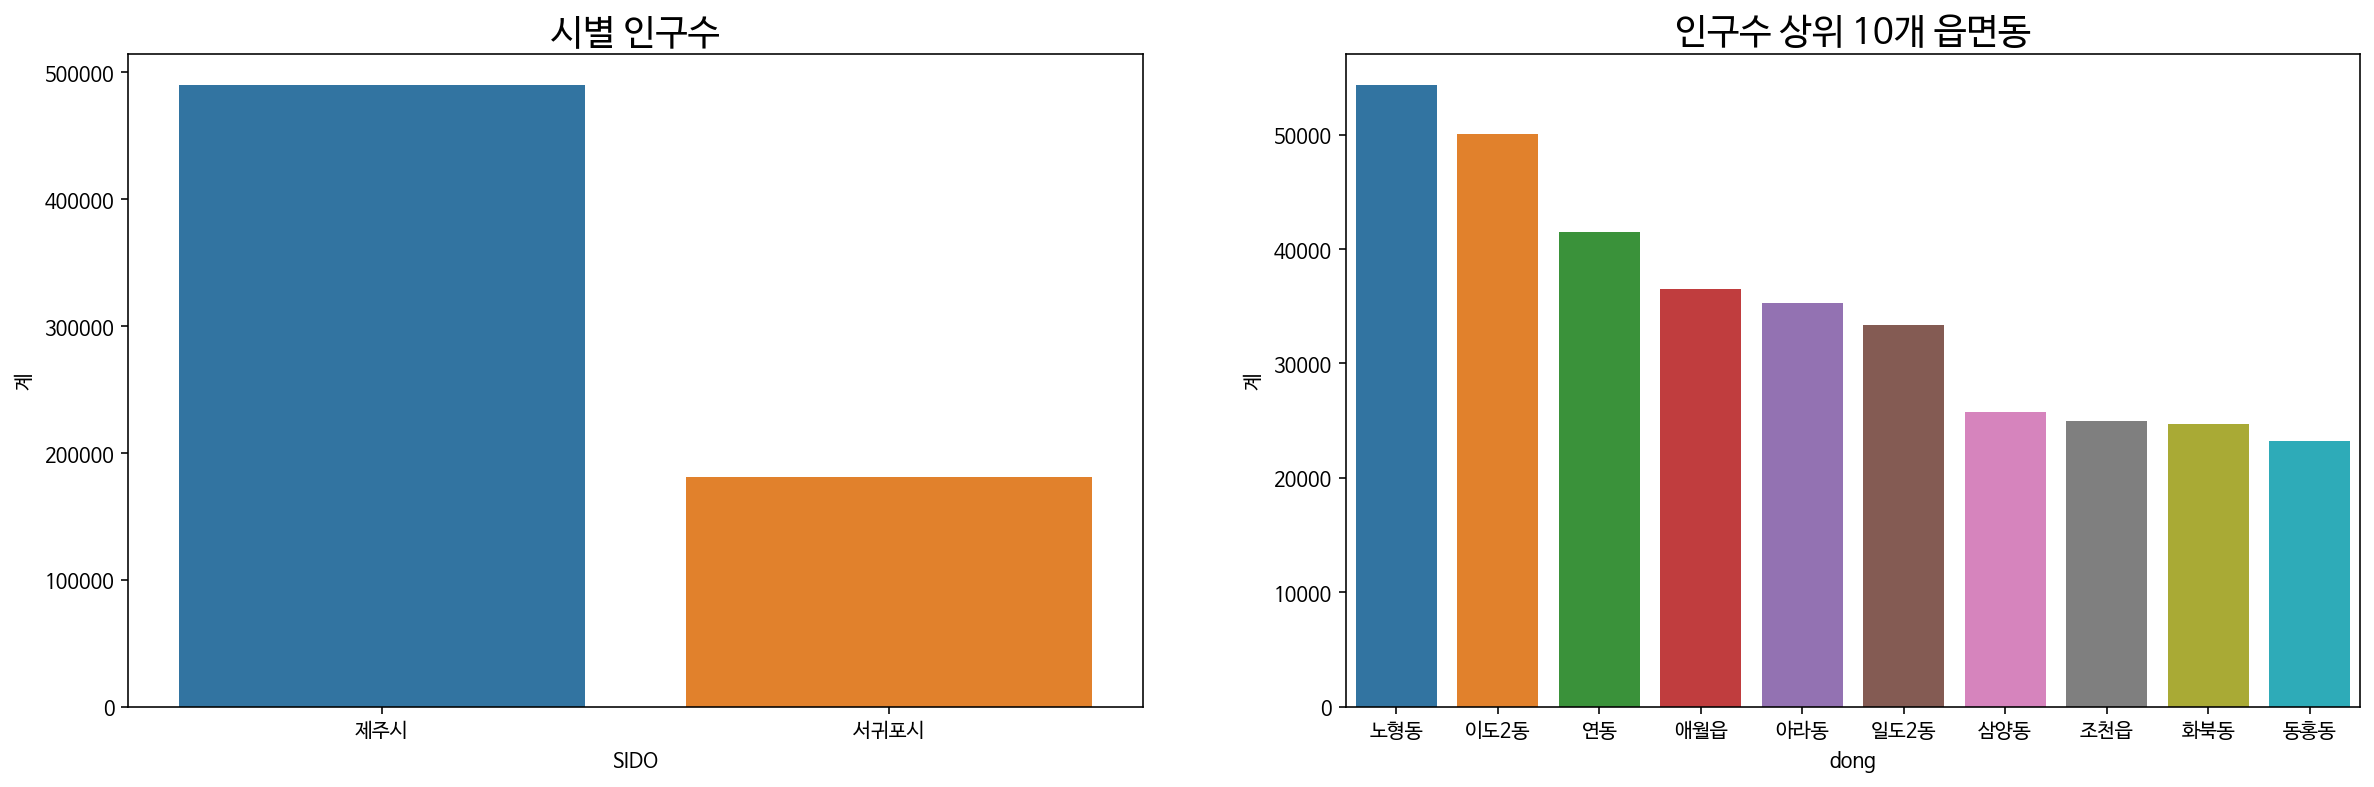

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))

sns.barplot(x='SIDO', y='계', data = people_df_dong.groupby('SIDO', sort=False)['계'].sum().reset_index(), ax=ax[0])
ax[0].set_title('시별 인구수', fontsize=18)
sns.barplot(x='dong', y='계', data = people_df_dong[:10], ax=ax[1])
ax[1].set_title('인구수 상위 10개 읍면동', fontsize=18)
plt.show()

In [ ]:
# 맵 위에 경계를 출력합니다.
f = folium.Figure(width=500, height=350)
m = folium.Map(location = [33.363007980715814, 126.53386465605664], zoom_start= 9)
m.add_to(f)

folium.Choropleth(geo_data=jeju_bound2,
                  name = '동별 재난지원금 사용액',
                  data = people_df_dong,
                  columns = ('dong', '계'),
                  key_on = 'feature.properties.ADM_DR_NM',
                  fill_color='OrRd',
                  fill_opacity=0.6,
                  line_color='white',
                  line_opacity=0.8,
                  legend_name='노령 인구수').add_to(m)
f

Output hidden; open in https://colab.research.google.com to view.

#### 3.2.2. 제주도 관광객

* 코로나로 인해 외국여행이 제한된 상황에서 관광객의 수는 어떻게 변화했는지 파악
* 관광객 데이터는 __제주공항을 이용한 입국객 수__를 사용, 5~8월 사이 외국인 입국객 수는 극히 적으므로 제외

* 출처 : [항공통계데이터, 한국공항공사](https://www.airport.co.kr/www/cms/frFlightStatsCon/airportStats.do?MENU_ID=1250#none)

In [ ]:
tour_df = pd.read_csv(os.path.join(kosis_path, '공항별 통계_19.01-20.01.csv'), encoding='euc-kr')

tour_df['YM'] = tour_df['연도'].astype(str) + tour_df['월'].astype(str)
tour_df['전년대비증감율'] = tour_df['여객계'].pct_change(periods=12)

* 2020년 5월 기준 내국인 입국객 수는 약 162만명 
* 올해 1월 입국객수는 작년보다 증가했지만, 신천지발 코로나가 심각해짐에 따라 입국객이 급감. 2월 입국객 수는 작년대비 55% 감소
* 2020년 입국객수는 작년대비 평균 약 26% 감소
* 시간이 지날수록 입국객 수는 점차 작년수준으로 회복되고 있으나 여전히 감소

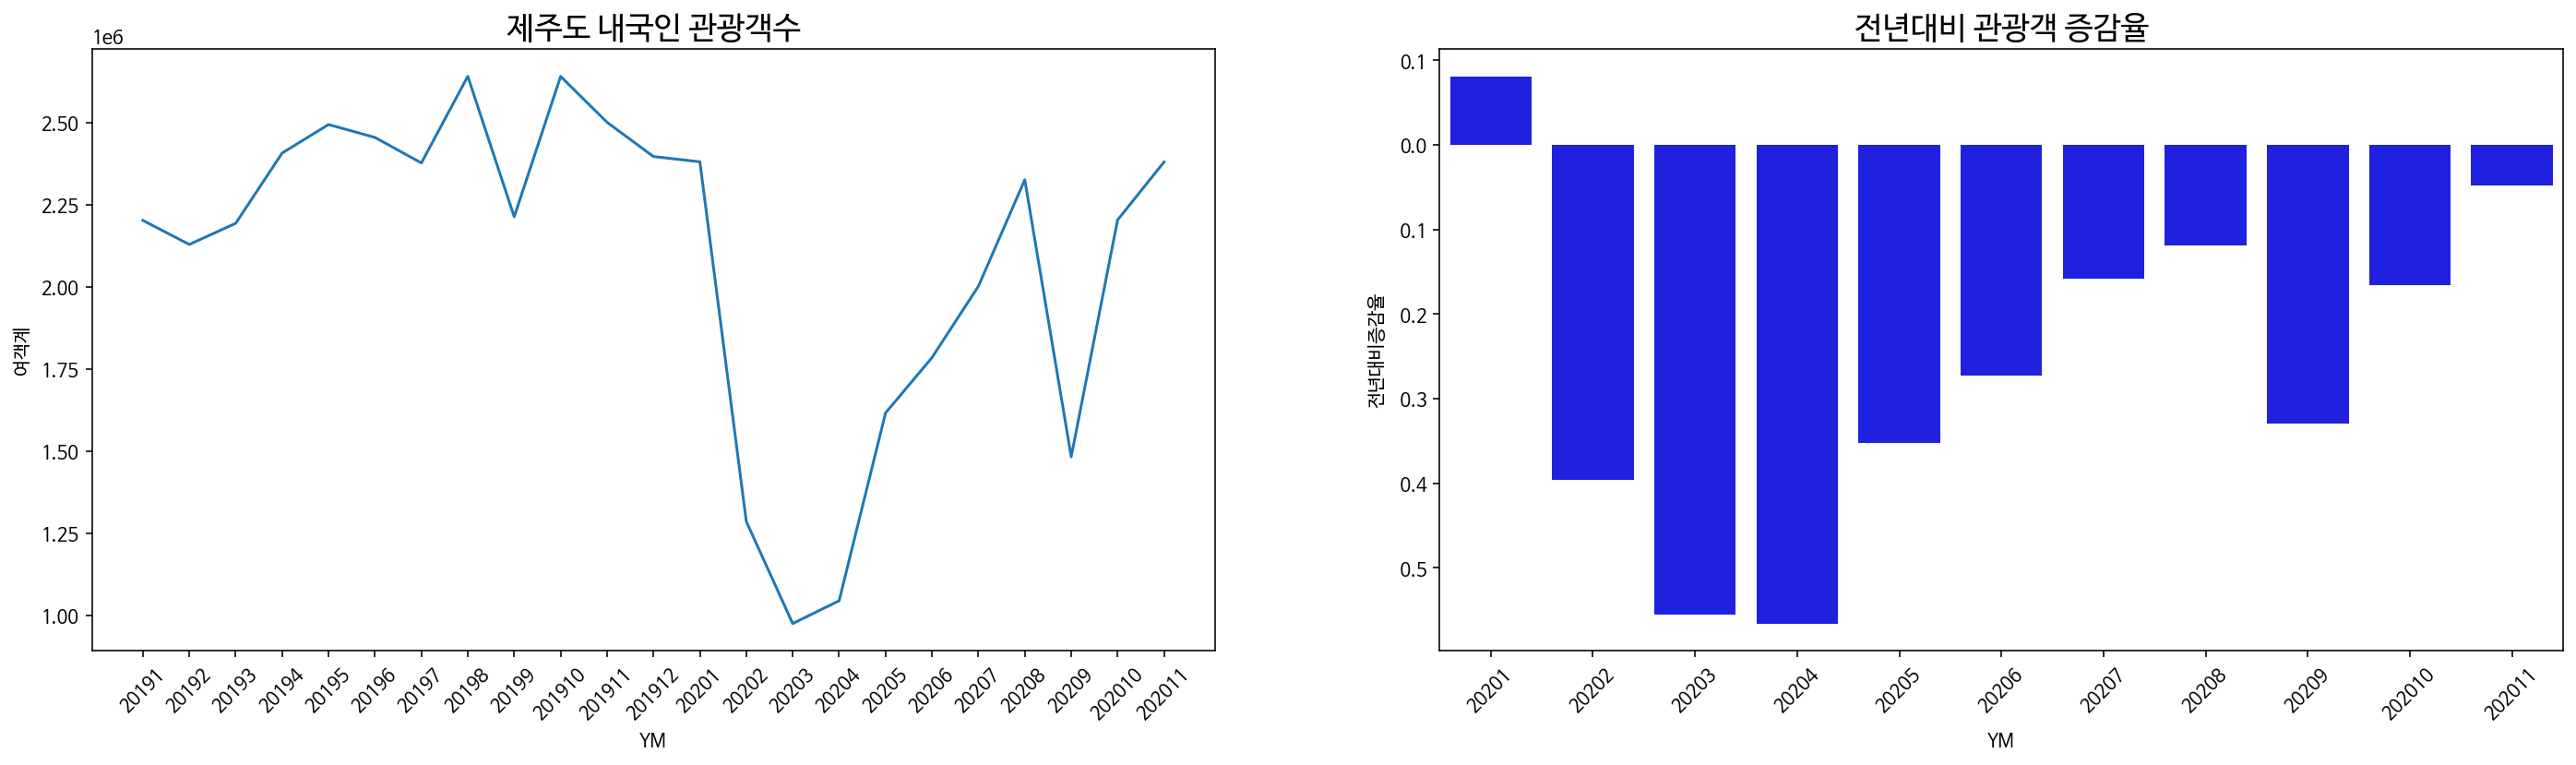

In [ ]:
#plot
fig, ax = plt.subplots(1,2, figsize=(24, 6))
sns.lineplot(x='YM', y='여객계', data=tour_df, ax=ax[0])
ax[0].set_title('제주도 내국인 관광객수', fontsize=17)
ax[0].set_xticklabels(tour_df.YM, rotation =45)

sns.barplot(x='YM', y='전년대비증감율', data=tour_df.loc[tour_df['전년대비증감율'].notnull()], color='blue', ax=ax[1])
ax[1].set_title('전년대비 관광객 증감율', fontsize=17)
ax[1].set_xticklabels(tour_df.YM[-11:], rotation =45)
plt.show()

### 3.3. 제주도 재난지원금

제주도에는 아래와 같은 재난지원금이 지급되었습니다.

* 정부 긴급재난지원금 : 지원 금액은 소득에 관계없이 1인 가구 40만 원, 2인 가구 60만 원, 3인 가구 80만 원, 4인 이상 가구에 최대 100만 원입니다.

* 제1차 제주형 재난긴급지원금 : 지난 4~5월에 지급됐으며, 중위소득 100%이하의 가구를 대상으로 가구원 수에 따라 최하 20만원에서 최대 50만원까지 모두 12만8490가구에 412억원을 지급했습니다.

* 제2차 제주형 재난긴급지원금 : 제주지역 소비 진작과 경제위기 완화를 위해 지난 8~10월에 전 도민에게 1인당 10만원을 일괄 지급해 모두 64만8160명에게 648억원을 지급했다고 합니다.

* 제주교육희망지원금 : 제주지역 만 7세 이상 초·중·고등학교에 재학 중인 학생 7만6천명에게 1인당 30만원을 지급했습니다.




*출처 : [긴급재난지원금 제주도 중복 지급, KBS](https://n.news.naver.com/article/056/0010829170)
[제주, 예술인·관광버스·청년에 전국 첫 3차 재난지원금, 조선일보](https://www.chosun.com/national/regional/jeju/2020/11/16/NMNHCRFVSBBSVI7Q6ZTINA6SLY/)*

In [ ]:
dis_spent = data.groupby('YM')['DisSpent'].sum().reset_index()
dis_spent['YM'] = dis_spent['YM'].astype(str)
print("총 재난지원금 사용 금액 : {0:0.0f}억원".format((dis_spent['DisSpent'].sum()/100000000)))
print("월 평균 재난지원금 사용 금액 : {0:0.0f}억원".format((dis_spent['DisSpent'].mean()/100000000)))

총 재난지원금 사용 금액 : 357억원
월 평균 재난지원금 사용 금액 : 89억원


* 제주도 재난지원금 예산은 약 1800억원입니다. 주어진 데이터는 총 357억원의 재난지원금 사용내역을 보이고 있으며, 약 20% 수준입니다

* 재난지원금은 5월에 가장 많은 금액이 사용되었으며, 8월 사용액은 약 5억 4천만원으로 급감했습니다

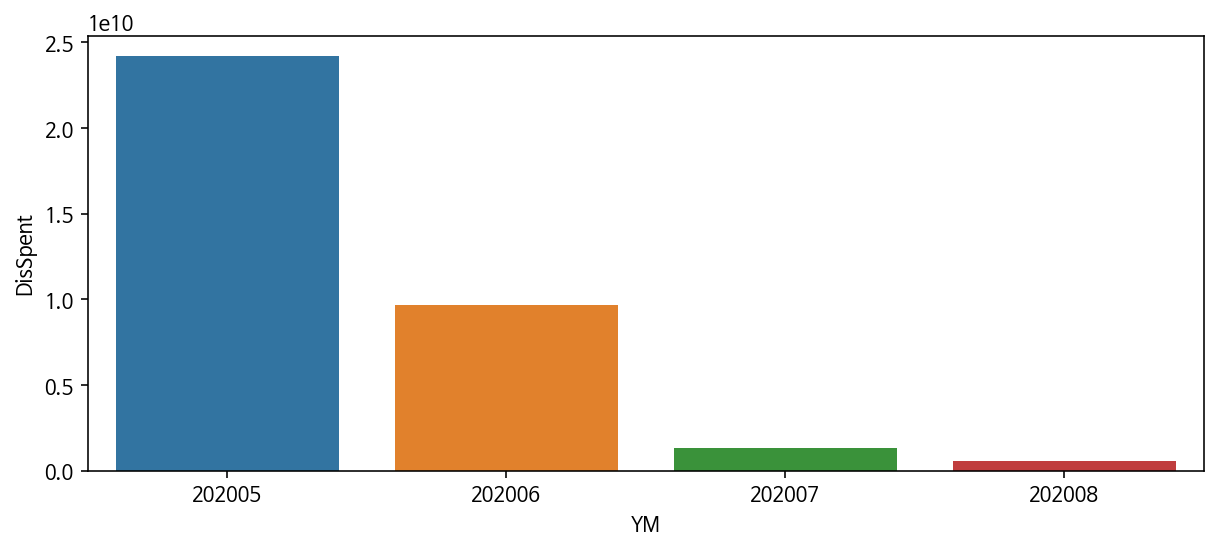

In [ ]:
#plot
fig = plt.figure(figsize=(10, 4))
sns.barplot(x='YM', y='DisSpent', data=dis_spent)
plt.show()

## 4. 지역, 업종별 소비 분석

## 체크2. 재난지원금은 어디 업종에서 많이 사용되었을까?

주어진 데이터는 2020년 5~8월 사이의 제주도에서 사용된 소비금액 데이터입니다.

전체적인 소비경향은 6월에 감소하다가 7~8월에 증가하고 있습니다

In [ ]:
m_sale = data.groupby('YM')['TotalSpent'].sum().reset_index()
m_sale['YM'] = m_sale['YM'].astype(str)
print("월별 평균 사용 금액 : {0:0.0f}억원".format((m_sale['TotalSpent'].mean()/1000000000)))

월별 평균 사용 금액 : 175억원


In [ ]:
print("총 사용 금액 : {0:0.0f}억원".format((m_sale['TotalSpent'].mean()/1000000000)))
print("월별 평균 사용 금액 : {0:0.0f}억원".format((m_sale['TotalSpent'].mean()/1000000000)))

총 사용 금액 : 175억원
월별 평균 사용 금액 : 175억원


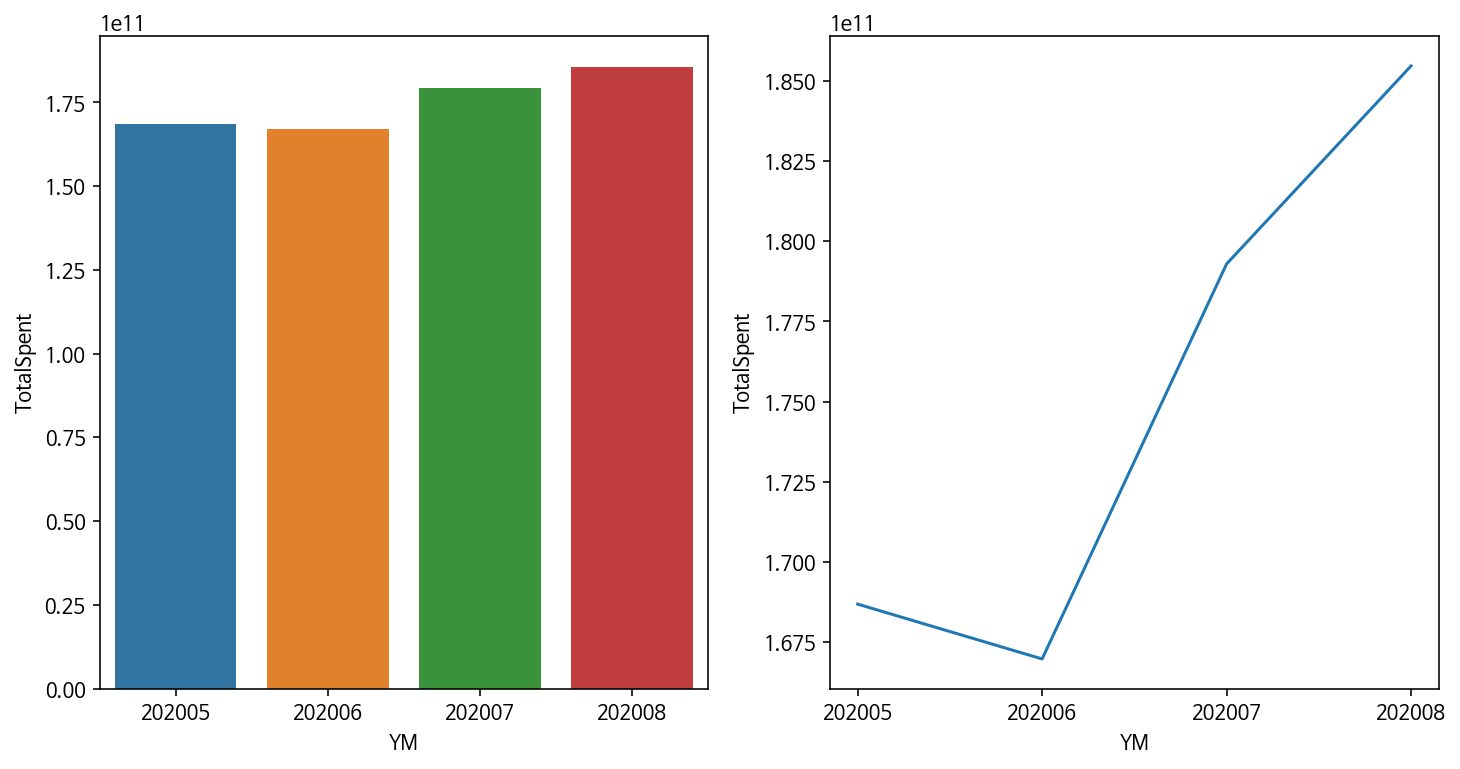

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(12, 6))
sns.barplot(x='YM', y='TotalSpent', data=m_sale, ax=ax[0])
sns.lineplot(x='YM', y='TotalSpent', data=m_sale, ax=ax[1])

### 2.1 재난지원금은 얼마나 사용되었을까?

[제주, 예술인·관광버스·청년에 전국 첫 3차 재난지원금, 조선일보](https://www.chosun.com/national/regional/jeju/2020/11/16/NMNHCRFVSBBSVI7Q6ZTINA6SLY/)에 따르면 제주도에는 아래와 같이 재난지원금이 지급되었습니다.

* 제1차 제주형 재난긴급지원금은 지난 4~5월에 지급됐으며, 소득 급감으로 절박한 상황에 처한 제주도민들의 생계를 실질적으로 보충하기 위한 긴급 구호의 성격으로 중위소득 100%이하의 가구를 대상으로 가구원 수에 따라 최하 20만원에서 최대 50만원까지 모두 12만8490가구에 412억원을 지급했습니다.

* 제2차 제주형 재난긴급지원금은 제주지역 소비 진작과 경제위기 완화를 위해 지난 8~10월에 전 도민에게 1인당 10만원을 일괄 지급해 모두 64만8160명에게 648억원을 지급했다고 합니다.

In [ ]:
df.head()

NameError: ignored

In [ ]:
dis_spent = df.groupby('YM')['DisSpent'].sum().reset_index()

NameError: ignored

재난지원금은 지급이 시작된 5월에 가장 많이 사용되었으며, 8월에는 약 5억4천만원 가량이 사용되었습니다.

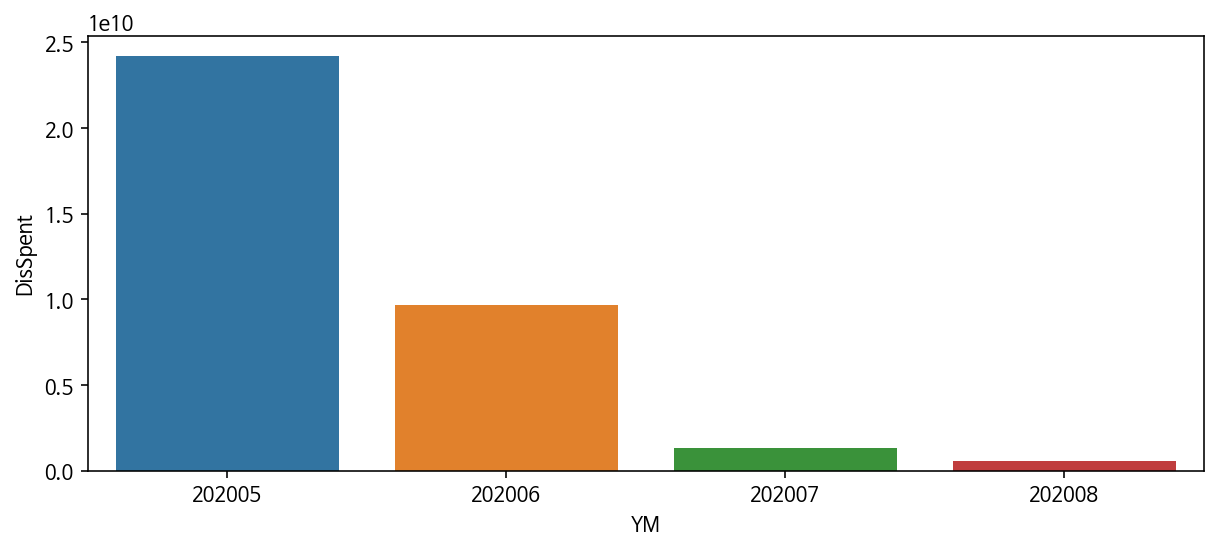

In [ ]:
#plot
fig = plt.figure(figsize=(10, 4))
sns.barplot(x='YM', y='DisSpent', data=dis_spent)
plt.show()

그렇다면 가장 많이 사용된 업종과 적게 사용된 업종은 어떤 것이 있을까요?

* 주로 많이 사용한 업종은 대부분 외식과 관련되어있습니다.
* 또한 생필품을 구매할 수 있는 업종인 슈퍼마켓, 편의점, 농협 등이 포함되있습니다.
* 눈에 띄는 업종은 '스포츠레저용품'과 '정장'입니다. 

In [ ]:
df = data

In [ ]:
# 업종별 재난지원금 소비금액 합
type_dis = df.groupby('Type')['DisSpent'].sum().sort_values().reset_index()
type_dis = type_dis.loc[type_dis['DisSpent'] !=0] #사용금액이 없는 업종은 제외합니다

# 지역별 재난지원금 소비금액 합
dong_dis = df.groupby('dong')['DisSpent'].sum().sort_values().reset_index()

In [ ]:
print(list(type_dis.Type[:20]))
print(list(type_dis.Type[-20:]))

['기타광학품', '정보서비스', '카메라', '택시', '기타교통수단', '유아원', '테니스장', '초중고교육기관', '제약회사', '견인서비스', '건강식품(회원제형태)', '화랑', '소프트웨어', '인삼제품', '기타보험', '보관창고업', '기타직물', '과학기자재', '컴퓨터학원', '여객선']
['중국음식', '미용원', '안경', '종합병원', '제과점', '일식회집', '정육점', '스넥', '정장', '의원', '농축수산품', '서양음식', '약국', '스포츠레져용품', '농협하나로클럽', '주유소', '편의점', '농축협직영매장', '슈퍼마켓', '일반한식']


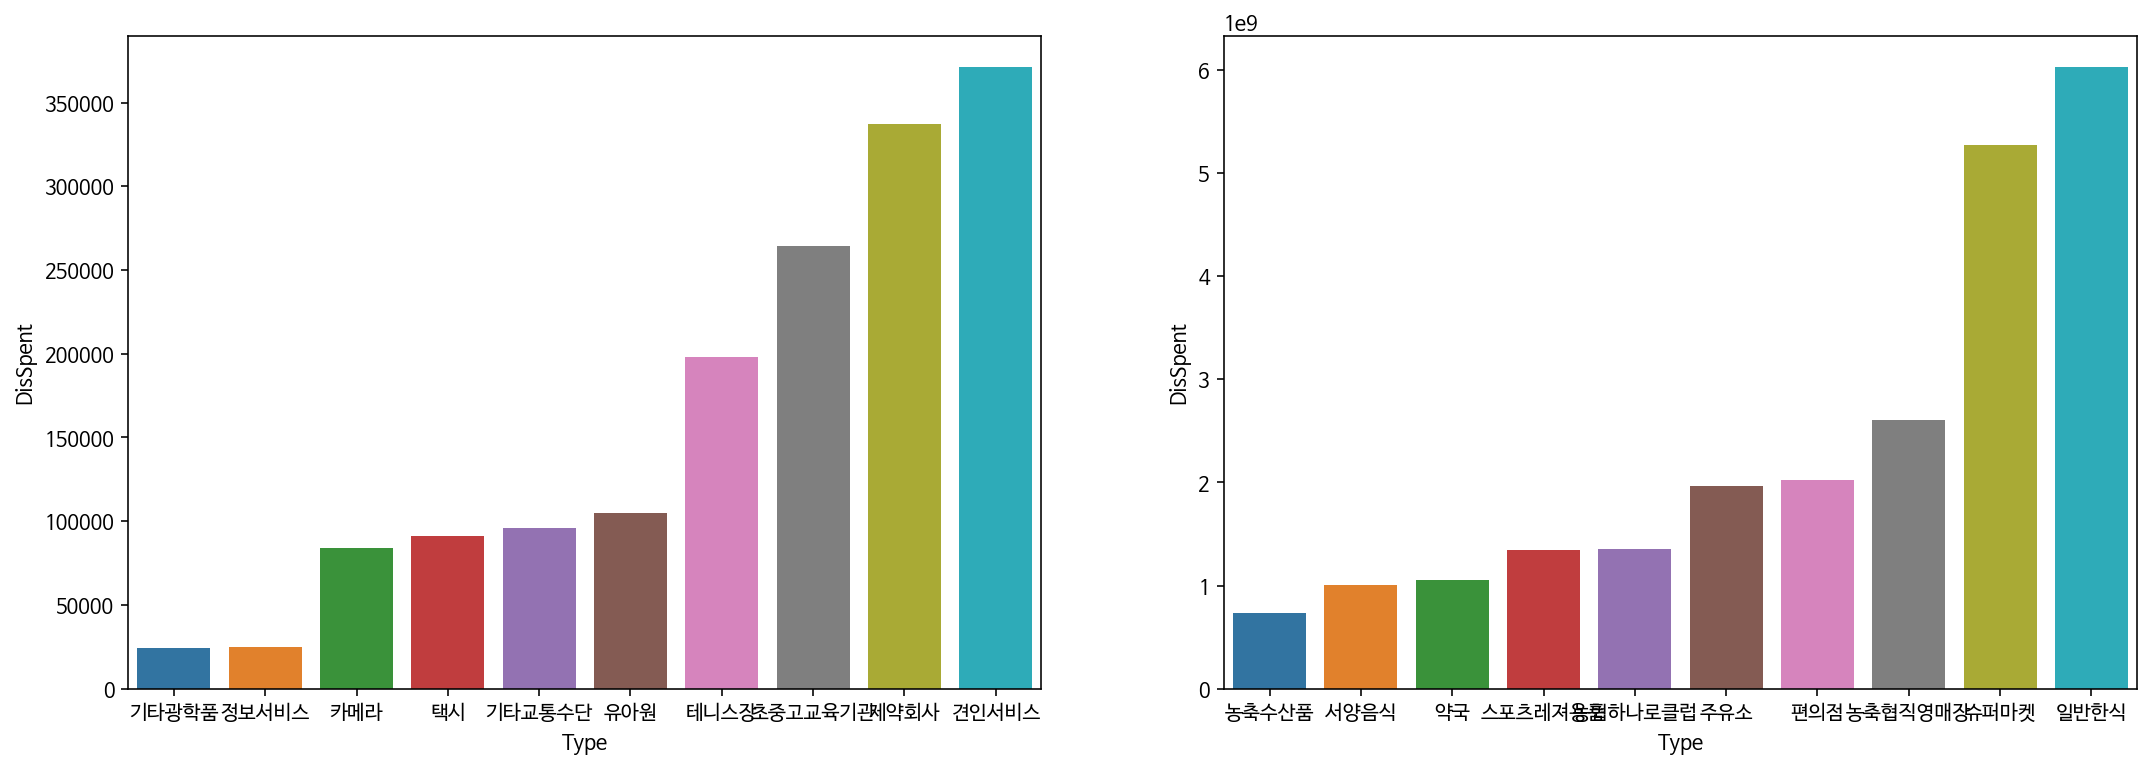

In [ ]:
#plot
fig, ax = plt.subplots(1,2, figsize=(18, 6))
sns.barplot(x='Type', y='DisSpent', data=type_dis[:10], ax=ax[0])
sns.barplot(x='Type', y='DisSpent', data=type_dis[-10:], ax=ax[1])

전체 소비금액 중 재난지원금 비중이 가장 큰 업종은 다음과 같습니다.

In [ ]:
df.head()

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,geometry,dong
0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06,POINT (126.1788936271016 33.30231529076244),한경면
1,2,2,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06,POINT (126.1788842681349 33.30276592288187),한경면
2,3,3,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06,POINT (126.179458342653 33.30097125427593),한경면
3,4,4,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,877055.9593,1.479766e+06,POINT (126.1794302729692 33.30232314934195),한경면
4,5,5,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,877055.4817,1.479866e+06,POINT (126.1794115582385 33.30322441283756),한경면


In [ ]:
#df['DisSpent_per'] = df['DisSpent'] / df['TotalSpent'] * 100
dis_per = df.groupby('Type').apply(lambda x: x['DisSpent'].sum() / x['TotalSpent'].sum() * 100)
dis_per = dis_per.sort_values().reset_index().rename(columns={0:'dis_per'})

비율로 살펴보니 의류관련 업종이 다양하게 나타나고 있습니다.

* 가장 높은 비율을 보이는 업종은 양품점입니다.
* 그 외 제화점, 아동의류, 맞춤복점, 신발, 스포츠의류, 케쥬얼의류, 내의판매점이 등장하고 있습니다.

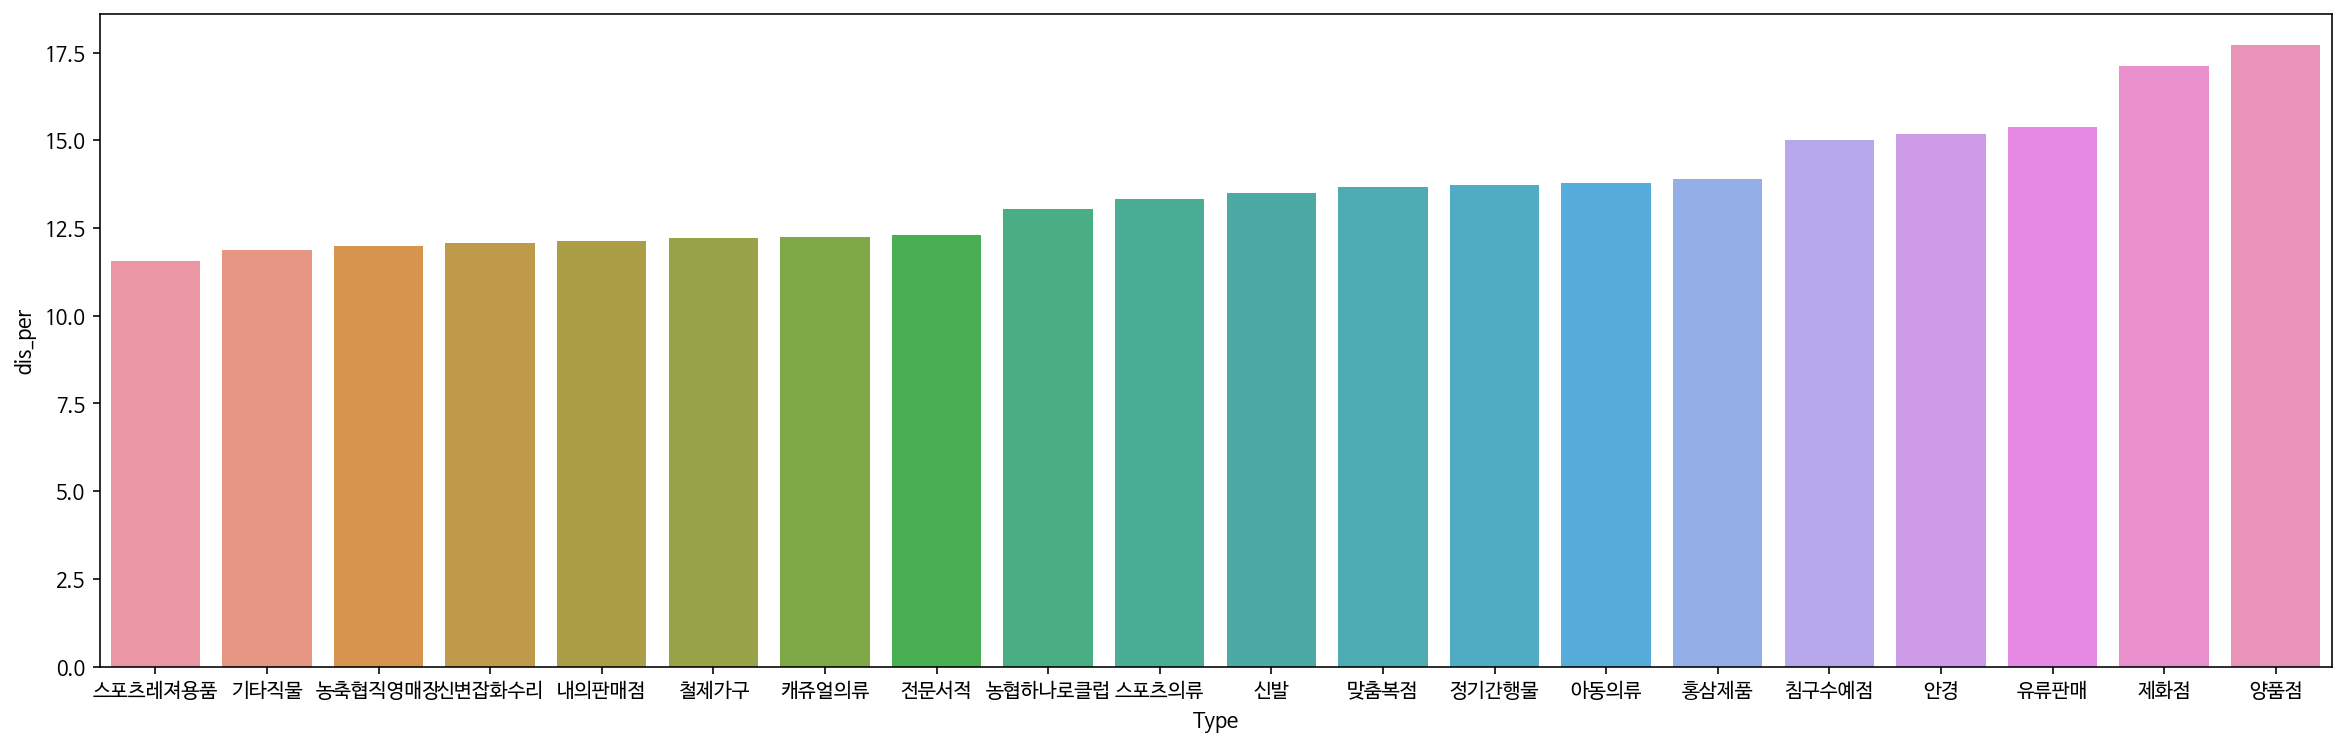

In [ ]:
#plot
fig, ax = plt.subplots(1,1, figsize=(20, 6))
sns.barplot(x='Type', y='dis_per', data=dis_per[-20:], ax=ax)
plt.show()

그렇다면 재난지원금의 매출비율이 높은 업종들은 재난지원금 사용량이 적은 8월에는 전체적인 매출이 감소하는 경향을 보였을까요?

In [ ]:
dis_top_type = dis_per[-30:]['Type']

In [ ]:
dis_top_df = df.loc[df['Type'].isin(list(dis_top_type))].groupby(['Type', 'YM'])['TotalSpent'].sum().reset_index()
dis_top_df['YM'] = dis_top_df['YM'].astype(str)

In [ ]:
dis_top_df['diff_5_8'] = dis_top_df.groupby(['Type'])['TotalSpent'].diff(periods=3)
dis_top_df['pct_5_8'] = dis_top_df.groupby(['Type'])['TotalSpent'].pct_change(periods=3) * 100

* 매출액이 가장 큰 폭으로 감소한 업종은 **스포츠레저용품**으로 약 19억원이 감소했습니다.
* 매출감소율이 가장 큰 업종은 **유류판매**이며, 8월 매출이 5월 대비 **약 93%**나 감소했습니다.
* 아동의류, 맞춤복점, 기타직물, 제화점 등 **의류 관련 업종**에서도 매출 감소폭이 크게 나타났습니다.
* **스포츠레져용품과 스포츠의류** 업종은 7번째와 22번째로 재난지원금이 많이 소비되었지만  9번째, 11번째 매출감소율이 높은 업종입니다. 즉 재난지원금으로 인하여 **매출증가에 도움이 되었으나 지속적인 매출로 이어지지 않은** 것으로 보입니다.
* **철제가구와 제화점** 업종은 전체 205개 업종 중 124번째, 128번째로 재난지원금을 소비한 업종으로 상대적으로 적은 재난지원금이 사용됐으며, 전체 매출감소율 상위 업종에 포함되었습니다. 이러한 업종은 기존 재난지원금이 **매출에 큰 도움이 되지 못했을뿐만 아니라 매출감소로 지속적인 어려움**을 겪을 것으로 예상됩니다. 비슷한 업종에 **추가적인 지원책 마련**이 필요해보입니다.

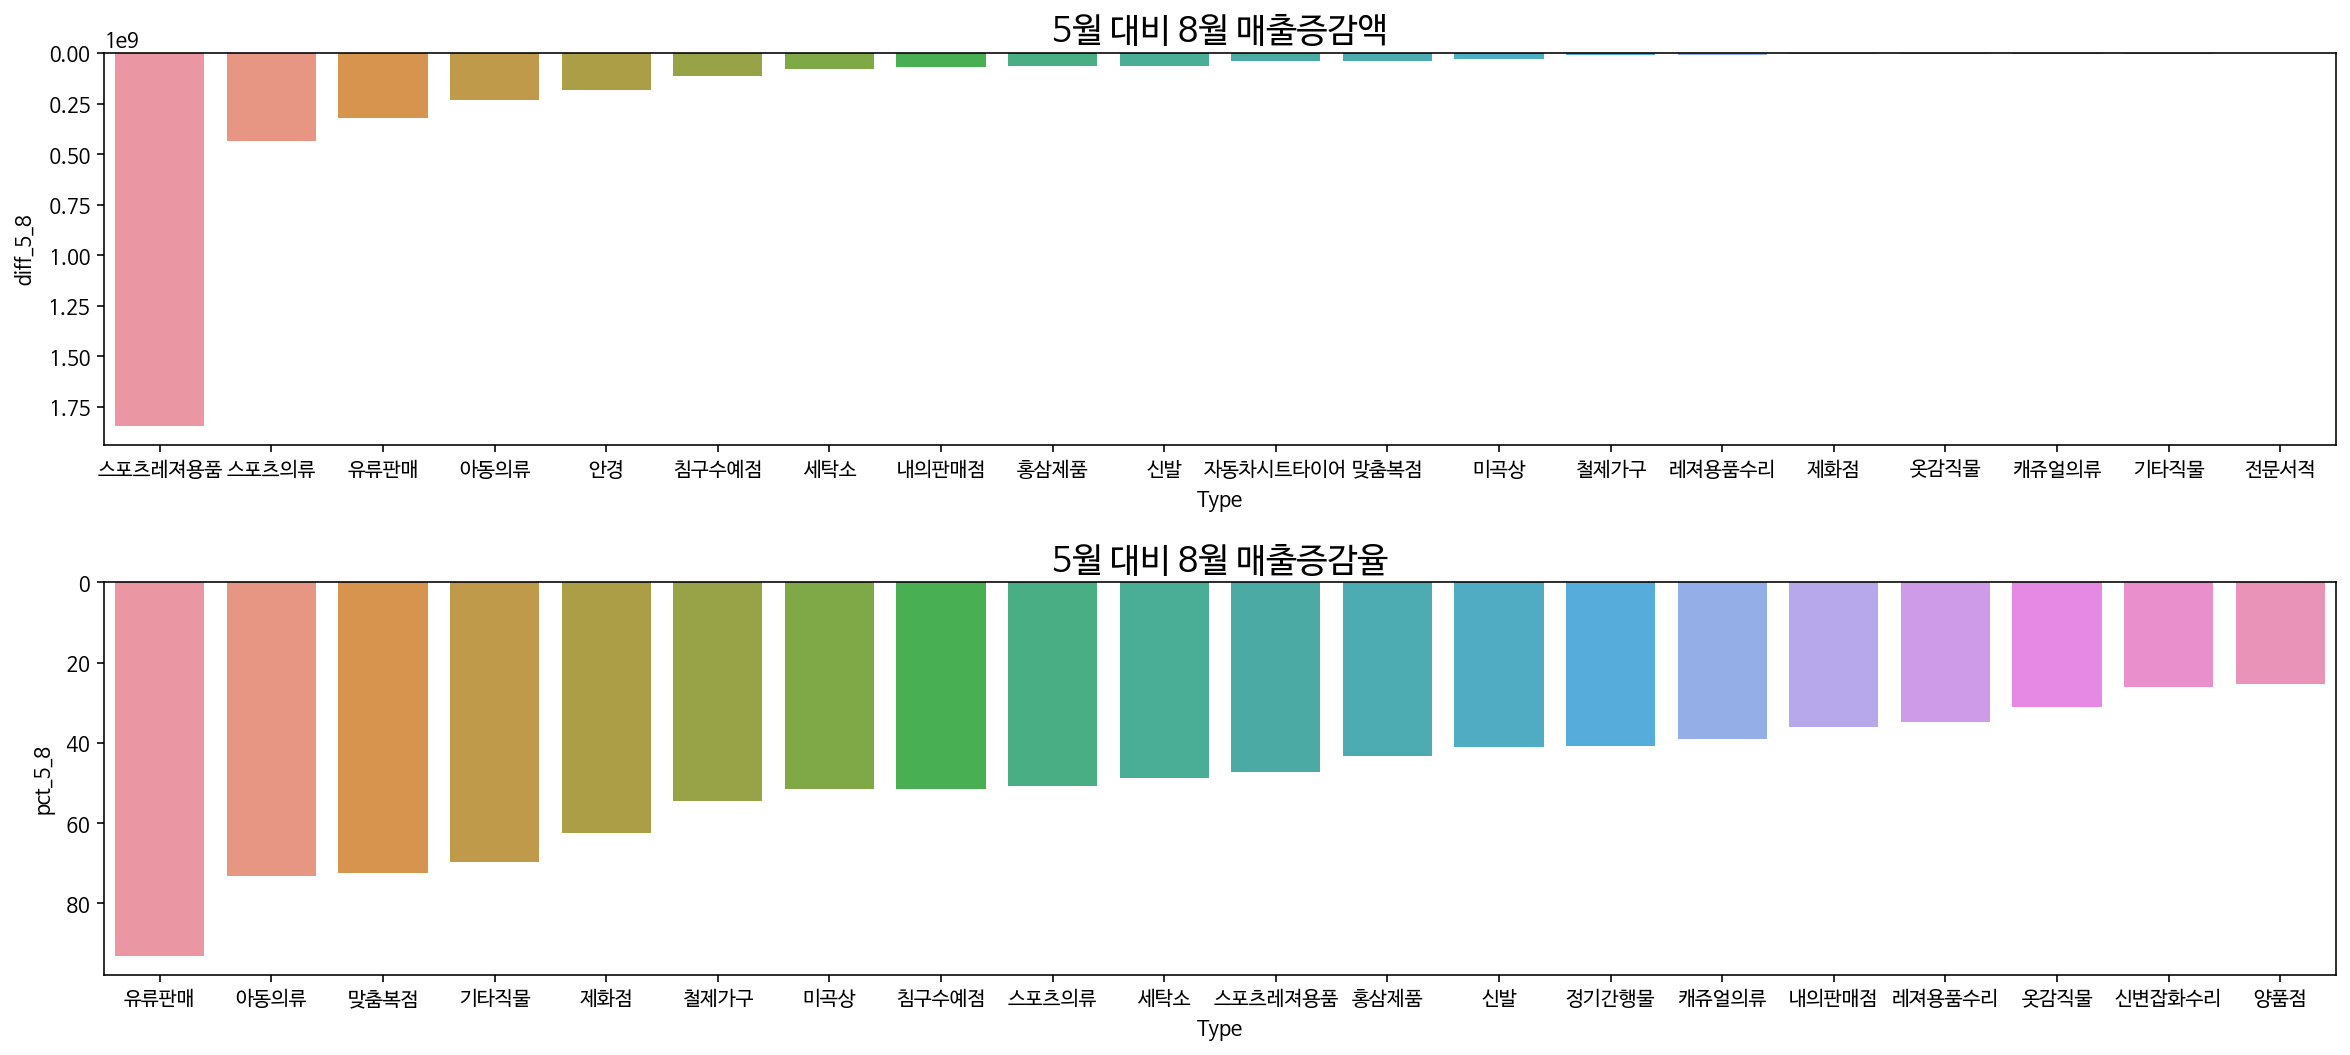

In [ ]:
temp = dis_top_df.loc[dis_top_df['diff_5_8'].notnull() ==True].sort_values('diff_5_8')[:20]
temp2 = dis_top_df.loc[dis_top_df['pct_5_8'].notnull() ==True].sort_values('pct_5_8')[:20]

#Plot
fig, ax = plt.subplots(2,1, figsize=(20, 8))
sns.barplot(x='Type', y='diff_5_8', data=temp, ax=ax[0])
ax[0].set_title('5월 대비 8월 매출증감액', fontsize=17)
sns.barplot(x='Type', y='pct_5_8', data=temp2, ax=ax[1])
ax[1].set_title('5월 대비 8월 매출증감율', fontsize=17)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
plt.show()

In [ ]:
dis_spent = data.groupby('Type')['DisSpent'].sum().sort_values(ascending=False).reset_index()
dis_spent.loc[dis_spent.Type.isin(temp2.Type)]

In [ ]:
dis_spent.loc[dis_spent.Type.isin(temp2.Type)]

,Type,DisSpent
6,스포츠레져용품,1340087205
21,스포츠의류,338195068
41,아동의류,97982899
42,침구수예점,97973757
49,신발,80881027
50,내의판매점,80606915
53,유류판매,76648161
60,홍삼제품,58593413
63,세탁소,52638358
93,맞춤복점,19291646


In [ ]:
# 업종별 재난지원금 소비금액 합
type_dis_8 = df.loc[df['YM'] == 202008].groupby('Type')['DisSpent'].sum().sort_values().reset_index()
type_dis_8 = type_dis_8.loc[type_dis_8['DisSpent'] !=0] #사용금액이 없는 업종은 제외합니다

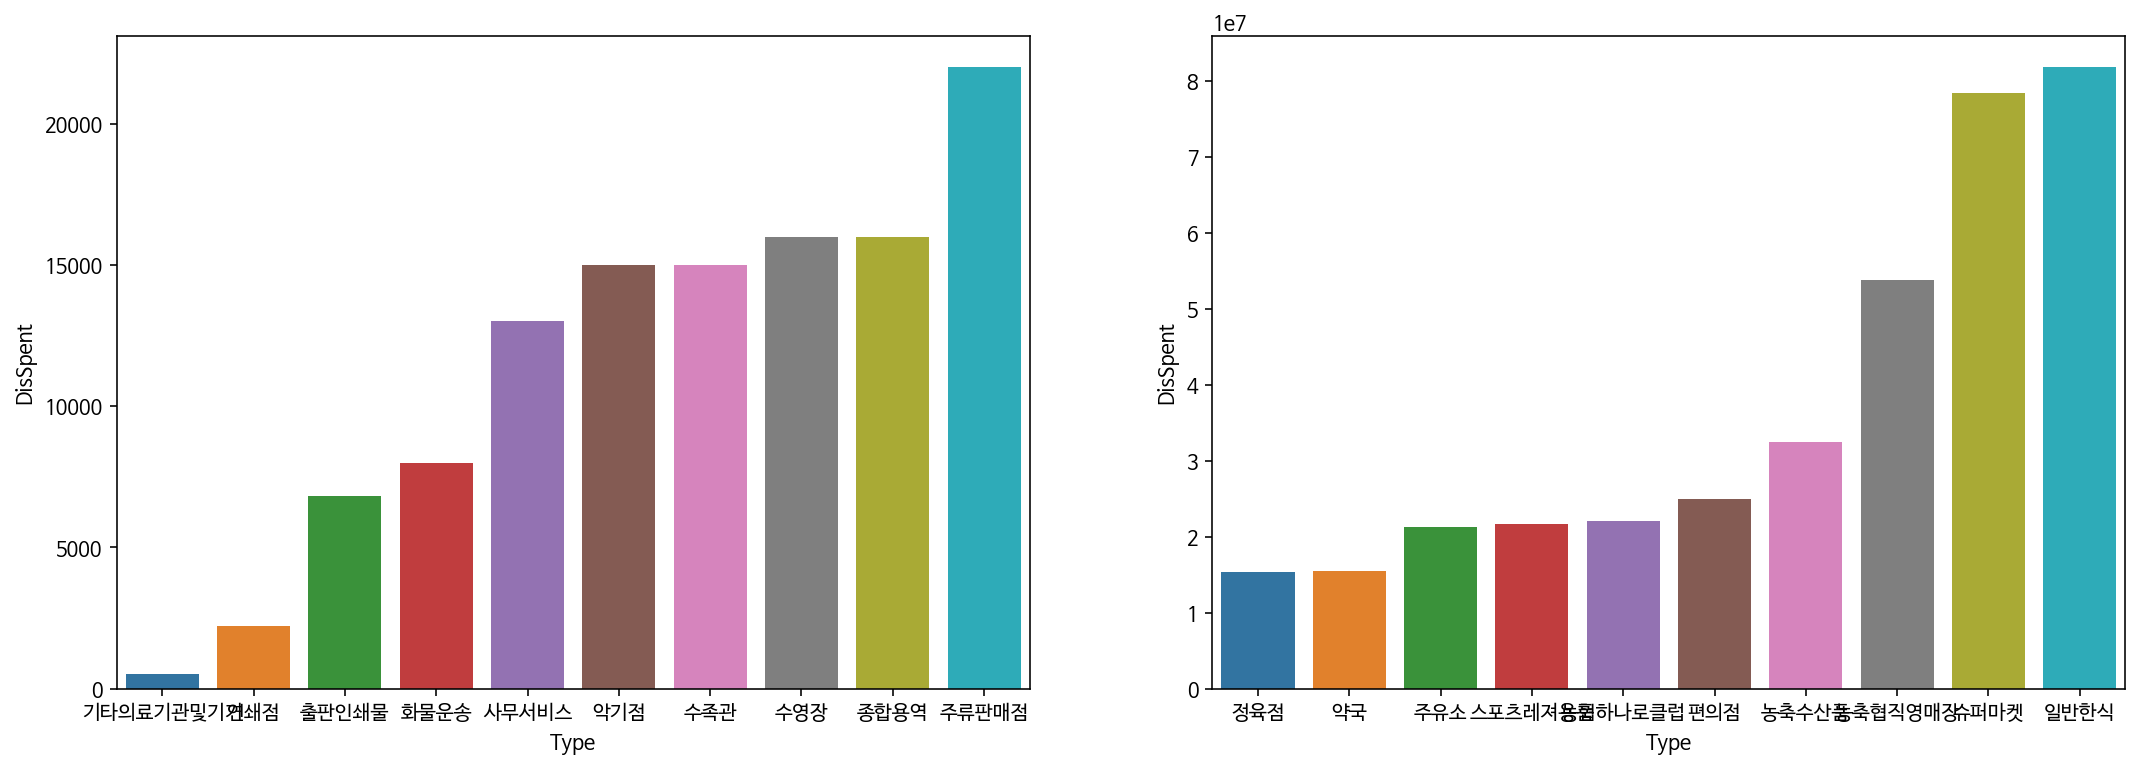

In [ ]:
#plot
fig, ax = plt.subplots(1,2, figsize=(18, 6))
sns.barplot(x='Type', y='DisSpent', data=type_dis_8[:10], ax=ax[0])
sns.barplot(x='Type', y='DisSpent', data=type_dis_8[-10:], ax=ax[1])

### 2.2 지역별 재난지원금 사용금액과 1인당 사용액

재난지원금은 소득기준으로 지급되었으나, 지역의 인구수에 비례해서 지급액이 증가할 가능성이 높습니다. 그렇다면 각 읍면동의 인구는 어느정도 일까요?

행정동명 인구는 [행정구역(읍면동)별/5세별 주민등록인구, kosis](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B04005)에 있습니다.

In [ ]:
people_dong = pd.read_csv(os.path.join(kosis_path, '제주시_읍면동_별_5세별_주민등록인구_202005.csv'), encoding='euc-kr')
people_dong.rename(columns={'시': 'SIGUNGU', '읍면동': 'dong'}, inplace=True)

In [ ]:
people_dong.head()

,SIGUNGU,dong,계,0 - 4세,5 - 9세,10 - 14세,15 - 19세,20 - 24세,25 - 29세,30 - 34세,35 - 39세,40 - 44세,45 - 49세,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+
0,제주시,한림읍,21202,623,909,873,909,1078,985,921,1341,1525,1957,1964,1874,1712,1224,1053,900,716,439,129,44,26
1,제주시,애월읍,36516,1376,2042,1855,1572,1784,1816,1781,2688,3131,3421,3207,3105,2528,1726,1373,1223,979,583,235,77,14
2,제주시,구좌읍,15452,350,582,532,613,695,695,622,1001,1061,1291,1404,1391,1302,947,848,756,690,467,149,50,6
3,제주시,조천읍,24976,850,1275,1078,1128,1388,1355,1242,1776,1896,2162,2210,2130,1849,1291,1059,946,716,413,142,61,9
4,제주시,한경면,9011,222,318,280,303,387,333,301,509,652,766,812,816,846,603,498,491,445,303,84,35,7


In [ ]:
people_dong.groupby('SIGUNGU')['계'].sum()

SIGUNGU
서귀포시    181059
제주시     489734
Name: 계, dtype: int64

제주시는 약 49만명, 서귀포시는 약 18만으로 서귀포시에 거주하고 있는 인원이 더 많습니다.

그렇다면 읍면동 단위로 인구를 구해보고, 인구당 사용된 소비금액, 재난지원금의 액수은 얼마나될까요

In [ ]:
people_dong_count = people_dong.groupby(['SIGUNGU', 'dong'])['계'].sum().reset_index()

ts_dong = df.groupby('dong')['TotalSpent'].sum().reset_index()
ds_dong = df.groupby('dong')['DisSpent'].sum().reset_index()

In [ ]:
people_dong_count = people_dong_count.merge(ts_dong, on='dong', how='left')
people_dong_count = people_dong_count.merge(ds_dong, on='dong', how='left')

In [ ]:
df.loc[df['dong'] == '이도1동']

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,geometry,dong,DisSpent_per


In [ ]:
people_dong_count.loc[people_dong_count['TotalSpent'].isnull()]

,SIGUNGU,dong,계,TotalSpent,DisSpent
1,서귀포시,대륜동,14467,NaN,NaN
3,서귀포시,대천동,13819,NaN,NaN
7,서귀포시,송산동,4195,NaN,NaN
9,서귀포시,영천동,5261,NaN,NaN
10,서귀포시,예래동,3926,NaN,NaN
11,서귀포시,정방동,2231,NaN,NaN
13,서귀포시,중앙동,3641,NaN,NaN
14,서귀포시,천지동,3556,NaN,NaN
16,서귀포시,효돈동,5254,NaN,NaN
20,제주시,도두동,3212,NaN,NaN


In [ ]:
people_dong_count.head()

,SIGUNGU,dong,계,TotalSpent,DisSpent
0,서귀포시,남원읍,18758,1.130425e+10,6.557438e+08
1,서귀포시,대륜동,14467,NaN,NaN
2,서귀포시,대정읍,21316,1.605682e+10,9.839008e+08
3,서귀포시,대천동,13819,NaN,NaN
4,서귀포시,동홍동,23185,1.572358e+10,1.184141e+09


In [ ]:
ds_dong

,dong,DisSpent
0,강정동,462505187
1,건입동,562897430
2,구좌읍,416000465
3,남원읍,655743785
4,내도동,64871703
...,...,...
68,호근동,75606818
69,화북이동,169955835
70,화북일동,889630334
71,회수동,14380578


In [ ]:
people_dong_count

,시,읍면동,계
0,서귀포시,남원읍,18758
1,서귀포시,대륜동,14467
2,서귀포시,대정읍,21316
3,서귀포시,대천동,13819
4,서귀포시,동홍동,23185
5,서귀포시,서홍동,10438
6,서귀포시,성산읍,15290
7,서귀포시,송산동,4195
8,서귀포시,안덕면,11974
9,서귀포시,영천동,5261


지역별 사용 금액은 다음과 같습니다.

In [ ]:
total_dis = df['DisSpent'].sum()
dong_dis['disSpent_per'] = dong_dis['DisSpent'] / total_dis

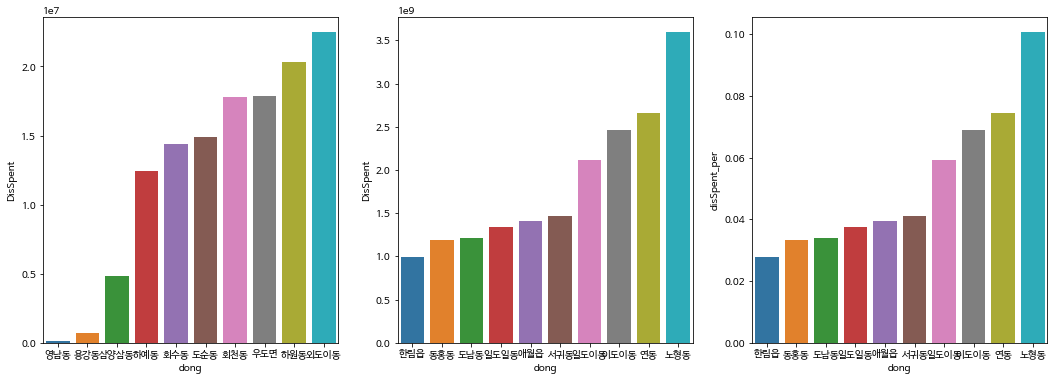

In [ ]:
#plot
fig, ax = plt.subplots(1,3, figsize=(18, 6))
sns.barplot(x='dong', y='DisSpent', data=dong_dis[:10], ax=ax[0])
sns.barplot(x='dong', y='DisSpent', data=dong_dis[-10:], ax=ax[1])
sns.barplot(x='dong', y='disSpent_per', data=dong_dis[-10:], ax=ax[2])

재난지원금을 가장 많이 소비한 5개 지역이 전체 지원금 중 30%를 소비했네요

In [ ]:
print("상위 5개 읍면동({})에서 전체 지원금의 {}%가 사용됨".format(list(dong_dis[-5:]['dong']), dong_dis[-5:]['disSpent_per'].sum() * 100))

상위 5개 읍면동(['서귀동', '일도이동', '이도이동', '연동', '노형동'])에서 전체 지원금의 34.442496726775026%가 사용됨


취미나 여가 활동으로 보이는 `스포츠레저용품`를 좀 더 자세히 보겠습니다. -> 시간대별 분석 추가하기



In [ ]:
sport_df = df.loc[df['Type'] == '스포츠레져용품']

In [ ]:
print(len(sport_df))
sport_df.head()

17076


,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,geometry,dong
698,699,699,202005,제주특별자치도,제주시,영세,스포츠레져용품,00시,13000,0,1,0,901494.6299,1.500724e+06,POINT (126.4395943601271 33.49383774402634),내도동
3656,3657,3657,202005,제주특별자치도,제주시,영세,스포츠레져용품,00시,82700,28700,8,1,911272.9421,1.504370e+06,POINT (126.5444826548504 33.52756972831754),건입동
4336,4337,4337,202005,제주특별자치도,제주시,중소,스포츠레져용품,00시,8000,0,3,0,913828.5386,1.502982e+06,POINT (126.5721347239417 33.51526921264603),화북이동
7664,7665,7665,202005,제주특별자치도,제주시,영세,스포츠레져용품,01시,11000,11000,1,1,911272.9421,1.504370e+06,POINT (126.5444826548504 33.52756972831754),건입동
8489,8490,8490,202005,제주특별자치도,제주시,영세,스포츠레져용품,01시,8500,0,2,0,940212.9812,1.504009e+06,POINT (126.8561458368372 33.52632860962898),구좌읍


In [ ]:
sport_dis = sport_df.groupby('Time')['DisSpent'].sum().sort_values().reset_index()
sport_dong = sport_df.groupby('dong')['DisSpent'].sum().sort_values().reset_index()

시간대로는 오후 1시부터 6시 사이에 가장 많은 소비가 이뤄지고 있다.

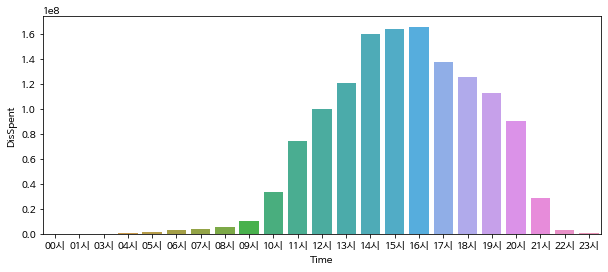

In [ ]:
#plot
fig = plt.figure(figsize=(10, 4))
sns.barplot(x='Time', y='DisSpent', data=sport_dis[2:], order=sorted(sport_dis[2:]['Time']))
plt.show()

지역 단위의 맵을 이용해서 시각화합니다.

먼저 `folium` 라이브러리를 이용해서 기본 맵을 생성합니다.

브이월드에서 API를 신청하면 한국에 맞는 기본 맵을 가져올 수도 있습니다.

In [ ]:
# 한라산 백록담 좌표(33.363007980715814, 126.53386465605664)를 중심으로 맵을 생성한다
f = folium.Figure(width=800, height=500)
#m = folium.Map(location = [33.363007980715814, 126.53386465605664], zoom_start= 10)

m = folium.Map(location = [33.363007980715814, 126.53386465605664], 
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/5AA2EC51-9D9A-35A1-ABD2-ED58B40D7745/Base/{z}/{y}/{x}.png',
               attr = '제주도',
               zoom_start= 10)

m.add_to(f)

경계 데이터를 가져와서 지도에 올려줍니다. 사용한 데이터는 [행정구역_읍면동(법정동), 공간정보포털](http://data.nsdi.go.kr/dataset/15145) 입니다.

In [ ]:
#경게 데이터
bound_df = gpd.read_file(os.path.join(nsdi_path, 'jeju_boundary_wgs84.geojson'))

In [ ]:
sum(bound_df['EMD_NM'] == '이도1동')

0

In [ ]:
# 맵 위에 경계를 출력합니다.
f = folium.Figure(width=800, height=500)
m = folium.Map(location = [33.363007980715814, 126.53386465605664], zoom_start= 10)
m.add_to(f)
# data를 사용하면 특정 데이터에 비례하여 색상이 변화합니다.
folium.Choropleth(geo_data=bound_df,
                  name = '동별 재난지원금 사용액',
                  data = sport_dong,
                  columns = ('dong', 'DisSpent'),
                  key_on = 'feature.properties.EMD_NM',
                  fill_color='OrRd',
                  fill_opacity=0.6,
                  line_color='white',
                  line_opacity=0.8,
                  legend_name='노령 인구수').add_to(m)

In [ ]:
m

Output hidden; open in https://colab.research.google.com to view.

folium이 무겁다면, 경계 데이터만 사용해서 출력하는 방법도 있다.
(출처 : https://medium.com/@thlee33/geopandas-%EA%B8%B0%EC%B4%88-fe1feecd2ab4)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
temp_bound = bound_df.merge(sport_dong.rename(columns={'dong': 'EMD_NM'}), on='EMD_NM', how='left')
temp_bound['DisSpent'].fillna(0, inplace=True)

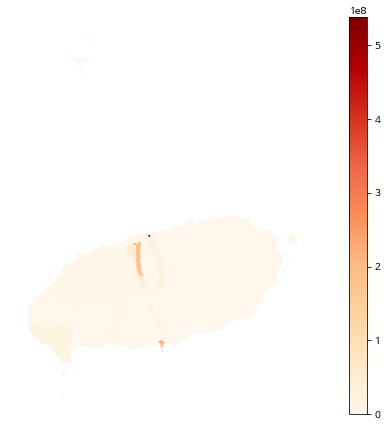

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

#plot 
column = 'DisSpent'
temp_bound.plot(column, legend=True, cax=cax, cmap='OrRd', ax=ax)
ax.set_axis_off()
plt.show()